# Ensemble methods with Matrix Factorization and Neural Collaborative Filtering using Neural Architecture Search

**Imports**

In [1]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Input, Embedding,  Dense, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow.keras.backend as k
from tensorflow.keras.models import Model
from surprise import Dataset
from surprise import Reader
import pandas as pd
import numpy as np
from surprise import SVD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import gc

Import dataset

In [2]:
df = pd.read_csv('./train_triplets_filtered_ratings.csv')
df.head()

,user_id,song_id,play_count,rating
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,1


In [3]:
df.shape

(32525889, 4)

In [4]:
n_users = df['user_id'].unique().shape[0]  # Number of users
n_users

558350

In [5]:
n_songs = df['song_id'].unique().shape[0]  # Number of songs
n_songs

36385

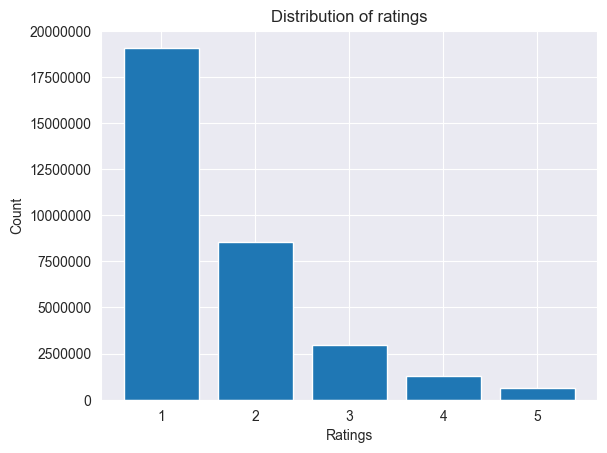

In [6]:
rating, n_rating = np.unique(df['rating'].values, return_counts=True)
plt.bar(rating, n_rating)
plt.ticklabel_format(style='plain')
plt.title('Distribution of ratings')
plt.ylabel('Count')
plt.xlabel('Ratings');

Encoding data into numeric values

In [7]:
user_le = LabelEncoder()
song_le = LabelEncoder()

df['user_id'] = user_le.fit_transform(df['user_id'])
df['song_id'] = song_le.fit_transform(df['song_id'])
df['rating'] = df['rating'] - 1 # Scale ratings between 0-4

Split dataset into training and testing

In [8]:
df = df.sample(frac=1, random_state=123)
n_samples = df.shape[0]
test_size = 0.2
validation_size = 0.1
n_training_samples = int(n_samples * (1-test_size-validation_size))
n_testing_samples = int(n_samples * test_size)
df_train, df_test, df_valid = df[:n_training_samples], df[n_training_samples:n_training_samples+n_testing_samples], df[n_training_samples+n_testing_samples:]
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(22768122, 4)
(6505177, 4)
(3252590, 4)


Convert user id and song id to values

### NeuCF

I use the Optuna library to intelligently search a space of possible hyperparameters for the NeuCF model.

In [11]:
def gpu_cleanup(objects):
    """Helps clean up things to prevent OOM during long training sessions"""
    if objects:
        del(objects)
    k.clear_session()
    gc.collect()


def objective(trial):

    MASK_ZERO = trial.suggest_categorical("MASK_ZERO", [True, False])
    EMB_LATENT_OUT = trial.suggest_int("EMB_LATENT_OUT", 2, 250, step=8)
    ACTIVATION = trial.suggest_categorical("ACTIVATION", ['relu', 'swish'])
    DROPOUT = trial.suggest_float("DROPOUT", 0, 0.5)
    LEARNING_RATE = trial.suggest_float("LEARNING_RATE", 1e-5, 1e-1, log=True)
    MLP_LAYERS = trial.suggest_int("MLP_LAYERS", 1, 5)
    BATCH_SIZE = trial.suggest_int("BATCH_SIZE", 100, 5000, step=100)
    EMB_R = trial.suggest_categorical("EMB_R", [None, '0', '1e-6'])
    if EMB_R is not None:
        EMB_R = regularizers.L2(float(EMB_R))
    EMB_INIT = trial.suggest_categorical("EMB_INIT", ["he_normal", "uniform"])
    MLP_ARCH = trial.suggest_categorical("MLP_ARCH", ["same", "dynamic"])
    GMF_DENSE = trial.suggest_int("gmf_dense", 16, 1024, step=8)

    user_in = Input(name='user_in', shape=(1,))
    song_in = Input(name='song_in', shape=(1,))
    # User attributes
    user_embedding = Embedding(name = 'u_emb_gmf', embeddings_regularizer=EMB_R, input_dim = n_users, output_dim = EMB_LATENT_OUT, mask_zero=MASK_ZERO, embeddings_initializer=EMB_INIT)(user_in)

    # Song Attributes
    book_embedding = Embedding(name = 'book_emb_gmf', embeddings_regularizer=EMB_R, input_dim = n_songs, output_dim = EMB_LATENT_OUT, mask_zero=MASK_ZERO, embeddings_initializer=EMB_INIT)(song_in)

    x = tf.keras.layers.concatenate([user_embedding, book_embedding])
    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    if MLP_ARCH == 'dynamic':  # Goes from large to small
        x = Dense(GMF_DENSE, activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
        x = Dropout(DROPOUT)(x)
        #x = BatchNormalization()(x)
        if MLP_LAYERS > 1:
            for i in range(MLP_LAYERS-1):
                x = BatchNormalization()(x)
                x = Dense(np.ceil(GMF_DENSE * (1 / (2 ** (i+1)))), activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
                x = Dropout(DROPOUT)(x)
    else:  # Stays same size
        for _ in range(MLP_LAYERS):
            x = BatchNormalization()(x)
            x = Dense(GMF_DENSE, activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
            x = Dropout(DROPOUT)(x)
    x = Dense(1)(x)
    model = Model(inputs=[user_in, song_in], outputs=x)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                      restore_best_weights=True,
                                                      monitor='val_root_mean_squared_error',
                                                      verbose=0,
                                                      mode='min',
                                                      min_delta=0.001)

    train_inputs = {'user_in':df_train['user_id'], 'song_in':df_train['song_id']}
    # Model training

    _ = model.fit(
        x=train_inputs,
        y=df_train['rating'],
        batch_size=BATCH_SIZE,
        epochs=100,
        verbose=0,
        validation_split=0.25,
        callbacks=[early_stopping, optuna.integration.TFKerasPruningCallback(trial, monitor='val_root_mean_squared_error')]
    )

    validation_inputs = {'user_in':df_valid['user_id'], 'song_in':df_valid['song_id']}
    results = model.evaluate(validation_inputs, df_valid['rating'], verbose=0)

    # Remove excess stuff
    gpu_cleanup([model, train_inputs, validation_inputs])

    return results[1]

# Using optuna
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(),  # Using TPE (Tree-structured Parzen Estimator) sampler
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10,  # Doesn't start pruning trials till at least 10 have completed
                                                               n_warmup_steps=3,   # Lets each model run at least 3 EPOCHS before stopping
                                                               interval_steps=1))  # Checks after each epoch of the validation score is not within the median
study.optimize(objective, n_trials=100, timeout=36000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-29 01:02:31,173] A new study created in memory with name: no-name-01ea1679-8f6a-478f-a16e-8dd98c043f28
[I 2023-04-29 01:19:48,303] Trial 0 finished with value: 0.8273029923439026 and parameters: {'MASK_ZERO': True, 'EMB_LATENT_OUT': 82, 'ACTIVATION': 'relu', 'DROPOUT': 0.05795448231717765, 'LEARNING_RATE': 0.012846857387813417, 'MLP_LAYERS': 1, 'BATCH_SIZE': 3100, 'EMB_R': None, 'EMB_INIT': 'he_normal', 'MLP_ARCH': 'dynamic', 'gmf_dense': 160}. Best is trial 0 with value: 0.8273029923439026.
[I 2023-04-29 01:49:06,160] Trial 1 finished with value: 0.826094388961792 and parameters: {'MASK_ZERO': True, 'EMB_LATENT_OUT': 146, 'ACTIVATION': 'relu', 'DROPOUT': 0.35407848389796365, 'LEARNING_RATE': 0.002167795678459833, 'MLP_LAYERS': 1, 'BATCH_SIZE': 2400, 'EMB_R': '0', 'EMB_INIT': 'he_normal', 'MLP_ARCH': 'same', 'gmf_dense': 248}. Best is trial 1 with value: 0.826094388961792.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:439: UserWarni

Number of finished trials: 21
Best trial:
  Value: 0.8233948349952698
  Params: 
    MASK_ZERO: False
    EMB_LATENT_OUT: 130
    ACTIVATION: relu
    DROPOUT: 0.2217647176591516
    LEARNING_RATE: 0.0014152882106222959
    MLP_LAYERS: 2
    BATCH_SIZE: 3600
    EMB_R: 0
    EMB_INIT: uniform
    MLP_ARCH: dynamic
    gmf_dense: 992


Evaluate the best model by retraining on both training and validation data

In [14]:
best_params = study.best_trial.params

def build_ncf(**kwargs):
    MASK_ZERO = kwargs['MASK_ZERO']
    EMB_LATENT_OUT = kwargs["EMB_LATENT_OUT"]
    ACTIVATION = kwargs["ACTIVATION"]
    DROPOUT = kwargs["DROPOUT"]
    LEARNING_RATE = kwargs["LEARNING_RATE"]
    MLP_LAYERS = kwargs["MLP_LAYERS"]
    BATCH_SIZE = kwargs["BATCH_SIZE"]
    EMB_R = kwargs["EMB_R"]
    if EMB_R is not None:
        EMB_R = regularizers.L2(float(EMB_R))
    EMB_INIT = kwargs["EMB_INIT"]
    MLP_ARCH = kwargs["MLP_ARCH"]
    GMF_DENSE = kwargs["gmf_dense"]
    k.clear_session()

    user_in = Input(name='user_in', shape=(1,))
    song_in = Input(name='song_in', shape=(1,))
    # User attributes
    user_embedding = Embedding(name = 'u_emb_gmf', embeddings_regularizer=EMB_R, input_dim = n_users, output_dim = EMB_LATENT_OUT, mask_zero=MASK_ZERO, embeddings_initializer=EMB_INIT)(user_in)

    # Song Attributes
    book_embedding = Embedding(name = 'book_emb_gmf', embeddings_regularizer=EMB_R, input_dim = n_songs, output_dim = EMB_LATENT_OUT, mask_zero=MASK_ZERO, embeddings_initializer=EMB_INIT)(song_in)

    x = tf.keras.layers.concatenate([user_embedding, book_embedding])
    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    if MLP_ARCH == 'dynamic':  # Goes from large to small
        x = Dense(GMF_DENSE, activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
        x = Dropout(DROPOUT)(x)
        if MLP_LAYERS > 1:
            for i in range(MLP_LAYERS-1):
                x = BatchNormalization()(x)
                x = Dense(np.ceil(GMF_DENSE * (1 / (2 ** (i+1)))), activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
                x = Dropout(DROPOUT)(x)
    else:  # Stays same size
        for _ in range(MLP_LAYERS):
            x = BatchNormalization()(x)
            x = Dense(GMF_DENSE, activation=ACTIVATION, kernel_regularizer=EMB_R)(x)
            x = Dropout(DROPOUT)(x)
    x = Dense(1)(x)
    return Model(inputs=[user_in, song_in], outputs=x)

model = build_ncf(**best_params)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['LEARNING_RATE']),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    restore_best_weights=True,
                                                    monitor='val_root_mean_squared_error',
                                                    verbose=0,
                                                    mode='min',
                                                    min_delta=0.001)

dict_inputs = {'user_in':pd.concat([df_train['user_id'],
                                    df_valid['user_id']]),
               'song_in':pd.concat([df_train['song_id'],
                                    df_valid['song_id']])}
# Model training

model.summary()

_ = model.fit(
    x=dict_inputs,
    y=pd.concat([df_train['rating'], df_valid['rating']]),
    batch_size=best_params['BATCH_SIZE'],
    epochs=100,
    verbose=1,
    validation_split=0.25,
    callbacks=[early_stopping]
)

validation_inputs = {'user_in':df_test['user_id'], 'song_in':df_test['song_id']}

results = model.evaluate(validation_inputs, df_test['rating'], verbose=1)
results

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
song_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
u_emb_gmf (Embedding)           (None, 1, 130)       72585500    user_in[0][0]                    
__________________________________________________________________________________________________
book_emb_gmf (Embedding)        (None, 1, 130)       4730050     song_in[0][0]                    
______________________________________________________________________________________________

[0.6730138659477234, 0.8203741908073425]

Testing RMSE was 0.8203

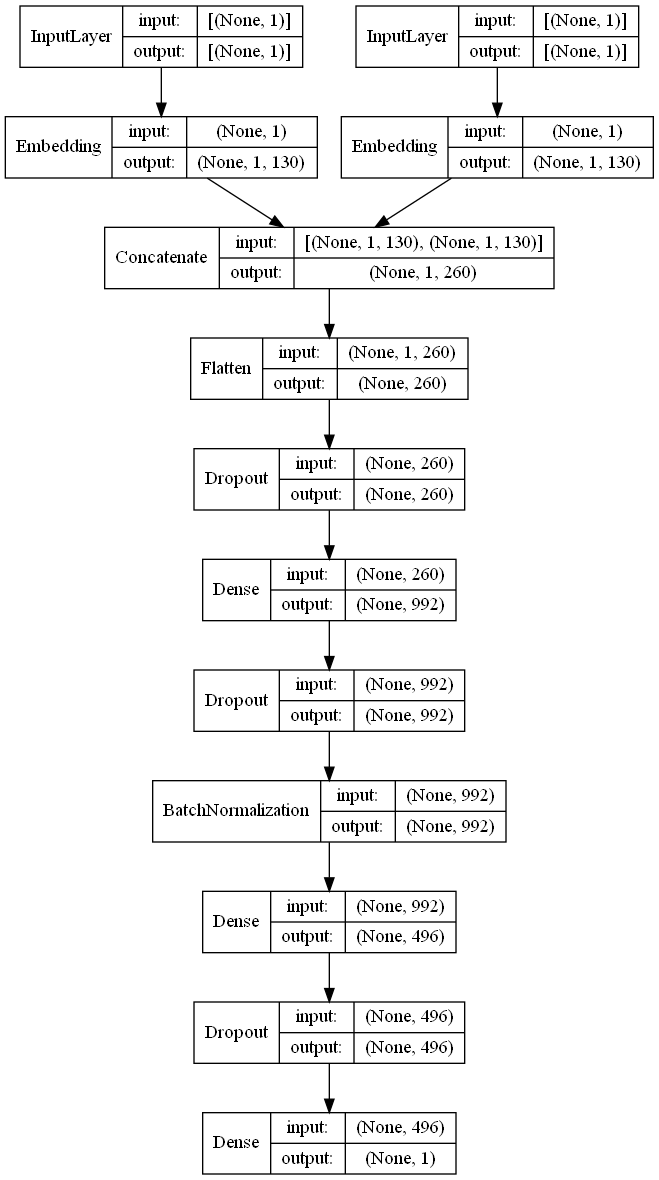

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### SVD

In [38]:
# Creating a training and testing dataset.
# The training set is a combining the df_train and df_valid dataset. This we still model using the same data as the NeuCF model
reader = Reader(rating_scale=(0,4))
train_data = Dataset.load_from_df(pd.concat([df_train, df_valid])[['user_id', 'song_id', 'rating']], reader)

In [39]:
### Fitting a default SVD model
algo = SVD()
predictions = algo.fit(train_data.build_full_trainset())

In [40]:
### Making predictions on the testing dataset
y_true = []
svd_pred = []
for row in df_test[['user_id', 'song_id', 'rating']].itertuples():
    pred = algo.predict(uid=row.user_id, iid=row.song_id, r_ui=None).est
    svd_pred.append(pred)
    y_true.append(row.rating)

mean_squared_error(y_true, svd_pred, squared=False)

0.8137737013568864

RMSE of SVD is 0.8137737013568864
RMSE of NeuCF is 0.8203741908073425

SVD beat the computationally expensive and large NeuCF model.

### Combining SVD and NeuCF

By combining the diversity of SVD and NeuCF together, we achieve a lower RMSE score

In [73]:
# Getting NeuCF predictions
nue_cf_pred = model.predict({'user_in':df_test['user_id'], 'song_in':df_test['song_id']}, verbose=1)
nue_cf_pred.shape[0]

203287/203287 [==============================] - 243s 1ms/step


6505177

Checking the portion of SVD and NeuCF predictions help more to reduce RMSE.

We do this by modifying the weighted portion of predictions towards the test RMSE

In [81]:
alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

combined_rmse = []
for a in alpha:
    combined_pred = []
    svd_portion = a
    nue_cf_portion = (1 - a)
    for idx in range(nue_cf_pred.shape[0]):  # Probably a faster way to do this with vectorized operations ¯\_(ツ)_/¯
        combined_pred.append((nue_cf_pred[idx] * nue_cf_portion) + (svd_pred[idx] * svd_portion))

    rmse = mean_squared_error(y_true, combined_pred, squared=False)
    print(f'Alpha {a}, RMSE: {rmse}')
    combined_rmse.append(rmse)

lowest_rmse = np.min(combined_rmse)
print(f"Lowest RMSE {round(lowest_rmse, 4)} with alpha {alpha[np.argmin(combined_rmse)]}")

Alpha 0, RMSE: 0.8203764286681468
Alpha 0.1, RMSE: 0.8147782224877447
Alpha 0.2, RMSE: 0.8102493770410829
Alpha 0.3, RMSE: 0.8068078990080015
Alpha 0.4, RMSE: 0.8044677445319819
Alpha 0.5, RMSE: 0.8032385391886814
Alpha 0.6, RMSE: 0.8031253839627823
Alpha 0.7, RMSE: 0.8041287500442131
Alpha 0.8, RMSE: 0.806244469132771
Alpha 0.9, RMSE: 0.8094638188945862
Alpha 1, RMSE: 0.813773701338681
Lowest RMSE 0.8031 with alpha 6


**Checking against the mean value of test data baseline**

For a baseline comparison, we compare the RMSE of the mean value for the testing data against itself. We then compare that RMSE value against the RMSE of combining SVD and NeuCF.

In [83]:
mean_rmse = mean_squared_error(
    df_test['rating'], [df_test['rating'].mean()] * df_test['rating'].shape[0], squared=False
)
percent_improvement = round((1 - (lowest_rmse / mean_rmse)) * 100, 1)
print(f"Improvement Over Mean Baseline: {percent_improvement}%")

Improvement Over Mean Baseline: 14.6%


In [85]:
percent_improvement = round((1 - (lowest_rmse / mean_squared_error(y_true, svd_pred, squared=False))) * 100, 1)
print(f"Improvement Over Only SVD: {percent_improvement}%")

Improvement Over Only SVD: 1.3%


In [88]:
percent_improvement = round((1 - (lowest_rmse / mean_squared_error(y_true, nue_cf_pred, squared=False))) * 100, 1)
print(f"Improvement Over Only SVD: {percent_improvement}%")

Improvement Over Only SVD: 2.1%
